# General Assembly - Santa Monica
## Data Science Immersive - Summer 2016

## Capstone Project
### Tiffany Wilson

Prepare the data for modeling.  The text will need to be cleaned, tokenized, and then a bag of words will need to be created.

In [1]:
import logging
import psycopg2
import datetime
from string import find, digits, maketrans, punctuation
import os
from types import *
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim import matutils
from gensim.models.phrases import Phrases
from gensim import models, similarities
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from pandas_confusion import ConfusionMatrix
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
from bs4 import BeautifulSoup
from getpass import getpass
import re
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [2]:
# Initialize the logger
SYS_NAME = 'NLP Property Desc Analysis V1.0'
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', filename='RE-NLP.log', level=logging.DEBUG)
logging.captureWarnings(True)

stops = set(stopwords.words("english")) 

In [3]:
class docProcessor:
    # The class will process a 'document'.  
    # The processing includes:
    # * removing any stopwords from the given list
    # * changing the case to lower
    # * removing punctuation*
    # * removing non-ASCII characters
    # * removing numeric digits IF specified to do so
    # * tokenizing the given documents and returning the results based on the rtnType.
    #
    #  rtnType - this specifies how the cleaned and tokenized doccument should be returned.
    #            If the rtnType = 'word' (default), then the results will be each word cleaned, tokenized and returned in a single list.
    #            If the rtnType = 'sentence', then the results will be a list of lists, where the text of each sentence is cleaned, tokenized,
    #                              and returned is in its own list.
    # EXAMPLE 1:  rtnType = 'word', document = 'The quick brown fox ran away. I will call you?' (ASSUMPTION:  stopwords are being removed)
    #             OUTPUT:  ['quick','brown','fox','ran','away','will','call']
    #
    # EXAMPLE 2:  rtnType = 'sentence', document = 'The quick brown fox ran away. I will call you?' (ASSUMPTION:  stopwords are being removed)
    #             OUTPUT:  [[quick','brown','fox','ran','away'],[will','call']]
    
    def __init__(self, rtnType='word', stopwordList=[], removeNumbers=True):
        if rtnType.lower() in ['word','sentence']:
            self.lrtnType = rtnType.lower()
        else:
            self.lrtnType - 'word'  #if given return type is not valid, default to 'word'
        self.lstopwordSet = set(stopwordList)
        self.lremoveNumbers=removeNumbers
    
    def removeDigits(self,docString):
        # Remove numeric digits from the givien string.
        if self.lremoveNumbers:
            return docString.translate(None, digits)
        else:
            return docString
    
    def removeStopwords(self,docString):
        if len(self.lstopwordSet) > 0:
            return " ".join([word for word in docString.split() if not word in self.lstopwordSet])
        else:
            return docString
    
    def removePunctuation(self,docString):
        return docString.translate(maketrans("",""), punctuation)
    
    def removeNonAscii(self,docString):
        return re.sub(r'[^\x00-\x7f]',r'', docString)
        
    def transform(self,docString):
        # Process the given docString
        if (type(docString) == NoneType): return []
        if (docString.strip() == ''): return []
        
        # Remove any non-ascii characters.
        tempDoc = self.removeNonAscii(docString)
                   
        # Change everything to lower case.
        tempDoc = tempDoc.lower()
        
        # Remove stopwords.
        tempDoc = self.removeStopwords(tempDoc)
        
        # Remove numbers, if instructed to do so.
        tempDoc = self.removeDigits(tempDoc)
        
        # If the return type is words, then remove punctuation and then tokenize.
        if (self.lrtnType == 'word'):
            # remove punctuation.
            tempDoc = self.removePunctuation(tempDoc)
            
            # tokenize and return the list of tokens.
            return tokenize.word_tokenize(tempDoc)
        else:
            # return type is sentences, so tokenize the sentences, and then remove punctuation.
            tempSentenceList = tokenize.sent_tokenize(tempDoc)
            returnList = []
            for sentence in tempSentenceList:  # Go through each sentence and remove punctuation, then tokenize it.
                tempDoc = self.removePunctuation(sentence)
                returnList.append(tokenize.word_tokenize(tempDoc))
            return returnList

In [4]:
def printLSATopics(lsaModel,vectorizer, geoCode):
    dictResults={'numTopics':len(lsaModel.components_),  # Number of topics.
                'topicItems':[]}  # List of lists of topicItems
    print 'TOP ' + str(dictResults['numTopics']) + ' TOPICS FOR PROPERTIES IN ' + geoCode.upper() + ":"
    terms = vectorizer.get_feature_names()
    for i, comp in enumerate(lsaModel.components_):
        termsInComp = zip(terms,comp)
        sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse=True) [:10]
        print "TOPIC %d: " % (i+1)
        termList=[]
        for term in sortedTerms:
            print term[0]
            termList.append(term[0])
        print " "
        dictResults['topicItems'].append(termList)
    return dictResults

## Load and begin cleaning data for processing and modeling.

In [5]:
# Get the data from the database.
password = getpass(prompt='Please enter your password to log in to the database:')
conn = psycopg2.connect('host=localhost dbname=re_ds user=tiffanydwilson password='+password+' port=5432')

Please enter your password to log in to the database:········


In [6]:
query = 'select geo_listings.geo_code, \
geo_listings.mls_id, \
listings.property_description \
from listings \
join geo_listings \
on listings.mls_id = geo_listings.mls_id \
order by geo_listings.geo_code asc, geo_listings.mls_id;'

dfData = pd.read_sql(sql=query,con=conn)
dfData.head()

,geo_code,mls_id,property_description
0,GSB,12179033,Beautiful 3 bedroom property in a great Garden...
1,GSB,14746595,"SHORT SALE Approved Price $389,000 as of 12/10..."
2,GSB,14749597,Hello All; there was a typo for the price; ple...
3,GSB,14768785,"Great stater home 2 bedroom 1 bath, convenient..."
4,GSB,14769155,Lovely tri-level Townhome in gated community w...


## Perform some exploratory data analysis.

In [9]:
# Rows and columns
dfData.shape

(8054, 3)

In [10]:
dfData.dtypes

geo_code                object
mls_id                  object
property_description    object
dtype: object

In [11]:
dfData.describe()

,geo_code,mls_id,property_description
count,8054,8054,8001
unique,3,8054,7950
top,GSB,PV15077573,12 NEW CONTEMPORARY TOWNHOUSES...NO INTERIOR U...
freq,3433,1,12


In [12]:
dfData.get_dtype_counts()

object    3
dtype: int64

In [13]:
dfData.count()

geo_code                8054
mls_id                  8054
property_description    8001
dtype: int64

In [14]:
# Remove any rows with null values in the property_description
dfCleaningData = dfData.dropna()
dfCleaningData.count()

geo_code                8001
mls_id                  8001
property_description    8001
dtype: int64

In [15]:
# Get the unique geo_codes.
geoCodeList = dfCleaningData['geo_code'].unique()
geoCodeList

array(['GSB', 'SBBeach', 'TheHill'], dtype=object)

## Try using Scikit Learn's Truncated SVD (LSA/LSI)

## Begin cleaning and prepping data.

Start with "TheHill" 

In [16]:
dp = docProcessor(rtnType='word',stopwordList=stops)
testParsedPD = [" ".join(dp.transform(s)) for s in dfCleaningData[dfCleaningData['geo_code'] == 'TheHill']['property_description']]
print 'len(testParsedPD): ' + str(len(testParsedPD))

len(testParsedPD): 1389


Create a TFIDF vector to pre-process the word data, so it is read for the Truncated SVD model.

In [17]:
vectorizer = TfidfVectorizer(stop_words=stops, use_idf=True, ngram_range=(1,3), max_df=0.2)
X = vectorizer.fit_transform(testParsedPD)
X[0]

<1x170530 sparse matrix of type '<type 'numpy.float64'>'
	with 72 stored elements in Compressed Sparse Row format>

In [18]:
X.shape

(1389, 170530)

Train the Truncated SVD model.

In [19]:
lsa = TruncatedSVD(n_components=10,n_iter=100)
lsa.fit(X)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
       random_state=None, tol=0.0)

Review the topics generated by the Truncated SVD model.

In [20]:
printLSATopics(lsa,vectorizer,'The Hill')

TOP 10 TOPICS FOR PROPERTIES IN THE HILL:
TOPIC 1: 
huge
school
back
unit
property
newer
bathrooms
outdoor
high
front
 
TOPIC 2: 
property
updated
school
award
including
include
guest
close
full
peninsula
 
TOPIC 3: 
formal dining room
high
award winning
french doors
back
gated
deck
panoramic
spectacular
double
 
TOPIC 4: 
community
shower
flooring
upstairs
gorgeous
walkin
wet
open floor
panoramic
three
 
TOPIC 5: 
opens
close
shopping
cabinets
glass
updated
gated
ceiling
street
system
 
TOPIC 6: 
baths
entry
easy
well
school
gated
quiet
recessed lighting
style
huge
 
TOPIC 7: 
lighting
shopping
double
ft
french
vaulted
entry
close
bar
top
 
TOPIC 8: 
huge
top
light
steel
street
tops
flat
formal dining room
living room fireplace
counter
 
TOPIC 9: 
high
back
newer
bathrooms
room fireplace
including
baths
location
pool spa
recessed
 
TOPIC 10: 
built
updated
offers
shower
bright
door
walk
remodeled kitchen
golf
including
 


{'numTopics': 10,
 'topicItems': [[u'huge',
   u'school',
   u'back',
   u'unit',
   u'property',
   u'newer',
   u'bathrooms',
   u'outdoor',
   u'high',
   u'front'],
  [u'property',
   u'updated',
   u'school',
   u'award',
   u'including',
   u'include',
   u'guest',
   u'close',
   u'full',
   u'peninsula'],
  [u'formal dining room',
   u'high',
   u'award winning',
   u'french doors',
   u'back',
   u'gated',
   u'deck',
   u'panoramic',
   u'spectacular',
   u'double'],
  [u'community',
   u'shower',
   u'flooring',
   u'upstairs',
   u'gorgeous',
   u'walkin',
   u'wet',
   u'open floor',
   u'panoramic',
   u'three'],
  [u'opens',
   u'close',
   u'shopping',
   u'cabinets',
   u'glass',
   u'updated',
   u'gated',
   u'ceiling',
   u'street',
   u'system'],
  [u'baths',
   u'entry',
   u'easy',
   u'well',
   u'school',
   u'gated',
   u'quiet',
   u'recessed lighting',
   u'style',
   u'huge'],
  [u'lighting',
   u'shopping',
   u'double',
   u'ft',
   u'french',
   u'vaulte

Process data for "SBBeach".

In [21]:
testParsedPD = [" ".join(dp.transform(s)) for s in dfCleaningData[dfCleaningData['geo_code'] == 'SBBeach']['property_description']]

vectorizer = TfidfVectorizer(stop_words=stops, use_idf=True, ngram_range=(1,3), max_df=0.2)
X = vectorizer.fit_transform(testParsedPD)

lsa = TruncatedSVD(n_components=10,n_iter=100)
lsa.fit(X)

printLSATopics(lsa,vectorizer,'South Bay Beach Cities')

TOP 10 TOPICS FOR PROPERTIES IN SOUTH BAY BEACH CITIES:
TOPIC 1: 
balcony
separate
top
built
enjoy
walkin
wood
back
counter
view
 
TOPIC 2: 
comes
steel appliances
glass
top
counter
water
award winning
tub
bright
back
 
TOPIC 3: 
south
recessed
see
ft
gas
redondo beach
open floor plan
village
property
house
 
TOPIC 4: 
enjoy
also
top
lighting
full
updated
guest
three
parking
main
 
TOPIC 5: 
school
huge
dining room
stainless steel appliances
upgraded
house
street
vaulted ceilings
attached
recessed
 
TOPIC 6: 
built
vaulted ceilings
townhome
updated
tub
ocean views
single
top
gorgeous
builtin
 
TOPIC 7: 
enjoy
spa
balcony
parking
shopping
formal
wood
updated
ceiling
dining room
 
TOPIC 8: 
close
separate
stainless steel appliances
tub
counter
tops
steel appliances
plenty
parking
street
 
TOPIC 9: 
balcony
system
winning
tub
pool
west
tile
view
award
entry
 
TOPIC 10: 
stainless steel appliances
tile
upgraded
formal
door
enjoy
steel appliances
west
glass
quiet
 


{'numTopics': 10,
 'topicItems': [[u'balcony',
   u'separate',
   u'top',
   u'built',
   u'enjoy',
   u'walkin',
   u'wood',
   u'back',
   u'counter',
   u'view'],
  [u'comes',
   u'steel appliances',
   u'glass',
   u'top',
   u'counter',
   u'water',
   u'award winning',
   u'tub',
   u'bright',
   u'back'],
  [u'south',
   u'recessed',
   u'see',
   u'ft',
   u'gas',
   u'redondo beach',
   u'open floor plan',
   u'village',
   u'property',
   u'house'],
  [u'enjoy',
   u'also',
   u'top',
   u'lighting',
   u'full',
   u'updated',
   u'guest',
   u'three',
   u'parking',
   u'main'],
  [u'school',
   u'huge',
   u'dining room',
   u'stainless steel appliances',
   u'upgraded',
   u'house',
   u'street',
   u'vaulted ceilings',
   u'attached',
   u'recessed'],
  [u'built',
   u'vaulted ceilings',
   u'townhome',
   u'updated',
   u'tub',
   u'ocean views',
   u'single',
   u'top',
   u'gorgeous',
   u'builtin'],
  [u'enjoy',
   u'spa',
   u'balcony',
   u'parking',
   u'shopping',

Process data for "GSB".

In [22]:
testParsedPD = [" ".join(dp.transform(s)) for s in dfCleaningData[dfCleaningData['geo_code'] == 'GSB']['property_description']]

vectorizer = TfidfVectorizer(stop_words=stops, use_idf=True, ngram_range=(1,3), max_df=0.2)
X = vectorizer.fit_transform(testParsedPD)

lsa = TruncatedSVD(n_components=10,n_iter=100)
lsa.fit(X)

printLSATopics(lsa,vectorizer,'Greater South Bay Cities')

TOP 10 TOPICS FOR PROPERTIES IN GREATER SOUTH BAY CITIES:
TOPIC 1: 
newer
house
pool
custom
property
family room
lighting
complex
front
attached
 
TOPIC 2: 
property
street
paint
lighting
perfect
floor plan
recessed lighting
house
master suite
attached
 
TOPIC 3: 
property
school
pool
park
also
ceiling
bedrooms baths
brand
desirable
walkin closet
 
TOPIC 4: 
newer
tops
park
upgraded
shower
complex
quiet
bedroom bath
dual
end
 
TOPIC 5: 
lot
pool
ceilings
lighting
steel
suite
sq
sink
recessed
lovely
 
TOPIC 6: 
baths
counter tops
tops
street
detached
also
stainless steel
school
recessed
direct
 
TOPIC 7: 
floor plan
upgraded
family room
stainless steel
property
laundry room
lots
upstairs
stainless steel appliances
balcony
 
TOPIC 8: 
front
hardwood floors
level
also
schools
location
nice
counters
family room
central
 
TOPIC 9: 
front
also
custom
doors
baths
lighting
upgraded
spa
level
washer dryer
 
TOPIC 10: 
light
upgraded
level
air
front
central
easy
suite
entertaining
hardwood floor

{'numTopics': 10,
 'topicItems': [[u'newer',
   u'house',
   u'pool',
   u'custom',
   u'property',
   u'family room',
   u'lighting',
   u'complex',
   u'front',
   u'attached'],
  [u'property',
   u'street',
   u'paint',
   u'lighting',
   u'perfect',
   u'floor plan',
   u'recessed lighting',
   u'house',
   u'master suite',
   u'attached'],
  [u'property',
   u'school',
   u'pool',
   u'park',
   u'also',
   u'ceiling',
   u'bedrooms baths',
   u'brand',
   u'desirable',
   u'walkin closet'],
  [u'newer',
   u'tops',
   u'park',
   u'upgraded',
   u'shower',
   u'complex',
   u'quiet',
   u'bedroom bath',
   u'dual',
   u'end'],
  [u'lot',
   u'pool',
   u'ceilings',
   u'lighting',
   u'steel',
   u'suite',
   u'sq',
   u'sink',
   u'recessed',
   u'lovely'],
  [u'baths',
   u'counter tops',
   u'tops',
   u'street',
   u'detached',
   u'also',
   u'stainless steel',
   u'school',
   u'recessed',
   u'direct'],
  [u'floor plan',
   u'upgraded',
   u'family room',
   u'stainless st

Let's process the property descriptions for all 3 areas.

In [23]:
testParsedPD = [" ".join(dp.transform(s)) for s in dfCleaningData['property_description']]

vectorizer = TfidfVectorizer(stop_words=stops, use_idf=True, ngram_range=(1,3), max_df=0.2)
X = vectorizer.fit_transform(testParsedPD)

lsa = TruncatedSVD(n_components=10,n_iter=100)
lsa.fit(X)

printLSATopics(lsa,vectorizer,'Greater South Bay Cities')

TOP 10 TOPICS FOR PROPERTIES IN GREATER SOUTH BAY CITIES:
TOPIC 1: 
unit
views
ocean
pool
flooring
house
back
newer
tile
location
 
TOPIC 2: 
ocean
unit
views
location
view
includes
interior
formal dining
open floor plan
dont
 
TOPIC 3: 
steel appliances
also
upgraded
lighting
see
stainless steel
includes
stainless steel appliances
newer
views
 
TOPIC 4: 
house
high
baths
three
pool
offers
top
includes
ceiling
complex
 
TOPIC 5: 
unit
property
location
complex
restaurants
nice
separate
recessed
outdoor
also
 
TOPIC 6: 
spa
upstairs
pool
lighting
walk
location
community
separate
school
built
 
TOPIC 7: 
property
well
light
stainless steel appliances
quiet
steel appliances
see
system
outdoor
spa
 
TOPIC 8: 
newer
house
dining room
counters
separate
built
park
dual
steel
double
 
TOPIC 9: 
spa
lighting
dining room
stainless steel appliances
entry
restaurants
neighborhood
pool
desirable
detached
 
TOPIC 10: 
offers
school
view
lots
counter tops
front
balcony
south
wonderful
light
 


{'numTopics': 10,
 'topicItems': [[u'unit',
   u'views',
   u'ocean',
   u'pool',
   u'flooring',
   u'house',
   u'back',
   u'newer',
   u'tile',
   u'location'],
  [u'ocean',
   u'unit',
   u'views',
   u'location',
   u'view',
   u'includes',
   u'interior',
   u'formal dining',
   u'open floor plan',
   u'dont'],
  [u'steel appliances',
   u'also',
   u'upgraded',
   u'lighting',
   u'see',
   u'stainless steel',
   u'includes',
   u'stainless steel appliances',
   u'newer',
   u'views'],
  [u'house',
   u'high',
   u'baths',
   u'three',
   u'pool',
   u'offers',
   u'top',
   u'includes',
   u'ceiling',
   u'complex'],
  [u'unit',
   u'property',
   u'location',
   u'complex',
   u'restaurants',
   u'nice',
   u'separate',
   u'recessed',
   u'outdoor',
   u'also'],
  [u'spa',
   u'upstairs',
   u'pool',
   u'lighting',
   u'walk',
   u'location',
   u'community',
   u'separate',
   u'school',
   u'built'],
  [u'property',
   u'well',
   u'light',
   u'stainless steel appliances

##  LDA with Scikit Learn & LDA Vis

We will reuse the TFIDF matrix (X) for the LDA model.

In [24]:
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tfidf.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [25]:
pyLDAvis.sklearn.prepare(lda_tfidf, X, vectorizer, R=15)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      91.814301        1       1  0.066131  0.000001
5       1.049757        1       2 -0.007795  0.000498
6       0.991682        1       3 -0.007555 -0.000306
2       0.952331        1       4 -0.007451 -0.000184
9       0.935437        1       5 -0.007457 -0.000134
8       0.867974        1       6 -0.007207  0.000016
4       0.864495        1       7 -0.007233  0.000004
3       0.862880        1       8 -0.007223  0.000005
0       0.846330        1       9 -0.007152  0.000035
1       0.814815        1      10 -0.007058  0.000065, topic_info=       Category       Freq                           Term      Total  loglift  \
term                                                                            
199936  Default   1.000000                            eye   1.000000  15.0000   
274097  Default   1.000000                        highest   1.000000  14.0000   
140706  Default   1.000000                covered parking   1.000000  13.0000   
607768  Default   1.000000                       vacation   1.000000  12.0000   
317021  Default   1.000000             landscaped grounds   1.000000  11.0000   
525696  Default   1.000000                          smart   1.000000  10.0000   
82496   Default   1.000000                         bridge   1.000000   9.0000   
532058  Default   1.000000             space entertaining   1.000000   8.0000   
445678  Default   1.000000                        poolspa   1.000000   7.0000   
460828  Default   1.000000                   quiet cul de   1.000000   6.0000   
460827  Default   1.000000                      quiet cul   1.000000   5.0000   
496664  Default   1.000000                   santa monica   1.000000   4.0000   
187026  Default   1.000000    entertaining family friends   1.000000   3.0000   
641975  Default   1.000000                    woodburning   1.000000   2.0000   
355370  Default   1.000000         luxurious master suite   1.000000   1.0000   
614319   Topic1  35.649244                          views  35.662680   0.0850   
395209   Topic1  34.862438                          ocean  34.875875   0.0850   
597257   Topic1  33.332198                           unit  33.345634   0.0850   
443554   Topic1  28.968487                           pool  28.981924   0.0849   
454813   Topic1  28.822126                       property  28.835563   0.0849   
288166   Topic1  28.717132                          house  28.730569   0.0849   
344521   Topic1  27.745500                       location  27.758937   0.0849   
612283   Topic1  27.670793                           view  27.684229   0.0849   
35664    Topic1  26.844848                           back  26.858284   0.0849   
236148   Topic1  25.344709                          front  25.358146   0.0849   
619337   Topic1  24.575492                           walk  24.588929   0.0849   
388603   Topic1  24.199758                          newer  24.213194   0.0848   
182361   Topic1  24.146699                          enjoy  24.160135   0.0848   
224111   Topic1  24.066290                       flooring  24.079726   0.0848   
497519   Topic1  23.599187                         school  23.612624   0.0848   
...         ...        ...                            ...        ...      ...   
391324   Topic9   0.006116                nice great area   0.075634   2.2571   
258592   Topic9   0.006116             great area gardena   0.075634   2.2571   
391323   Topic9   0.005904                     nice great   0.101050   1.9320   
585645   Topic9   0.003884               trader joes much   0.073895   1.8262   
275424   Topic9   0.003884               hills hr fitness   0.073896   1.8261   
544315   Topic9   0.003884          starbucks coffee bean   0.073896   1.8261   
60513    Topic9   0.003884               bean amc rolling   0.073896   1.8261   
307708   Topic9   0.003884                      joes much   0.073896 

Test the LDA model using term counts, NOT IDF.

In [26]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
#                                 lowercase = False,
#                                 token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.2,
                                ngram_range=(1,3))
dtm_tf = tf_vectorizer.fit_transform(testParsedPD)

# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [27]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, R=15)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      52.494205        1       1  0.392125 -0.008600
5       9.384850        1       2  0.049355  0.223078
2       8.992433        1       3  0.086878 -0.146538
0       5.289750        1       4 -0.074880 -0.007439
9       4.302341        1       5 -0.072868 -0.015570
7       4.006290        1       6 -0.077685 -0.007551
6       3.975965        1       7 -0.073230 -0.013324
1       3.952001        1       8 -0.077424 -0.007813
8       3.883223        1       9 -0.078222 -0.007560
4       3.718941        1      10 -0.074048 -0.008684, topic_info=       Category         Freq                Term        Total  loglift  \
term                                                                     
565038  Default  1883.000000                unit  1883.000000  15.0000   
581832  Default  2315.000000               views  2315.000000  14.0000   
421563  Default  1819.000000                pool  1819.000000  13.0000   
432859  Default  1449.000000            property  1449.000000  12.0000   
113863  Default  1160.000000           community  1160.000000  11.0000   
117350  Default   841.000000             complex   841.000000  10.0000   
225091  Default   630.000000                  ft   630.000000   9.0000   
273463  Default  1700.000000               house  1700.000000   8.0000   
516048  Default   630.000000                  sq   630.000000   7.0000   
516101  Default   543.000000               sq ft   543.000000   6.0000   
400031  Default  1260.000000             parking  1260.000000   5.0000   
234619  Default   925.000000               gated   925.000000   4.0000   
505458  Default  1193.000000                 spa  1193.000000   3.0000   
34908   Default  1275.000000             balcony  1275.000000   2.0000   
376394  Default  2361.000000               ocean  2361.000000   1.0000   
151273   Topic1  1520.788370         dining room  1521.286349   0.6441   
258002   Topic1  1522.693892                high  1523.209056   0.6441   
220273   Topic1  1419.102066              formal  1419.599569   0.6441   
490426   Topic1  1390.325246              shower  1390.876569   0.6441   
560810   Topic1  1167.860425                 tub  1168.364924   0.6440   
577126   Topic1  1129.829166             vaulted  1130.327749   0.6440   
385165   Topic1  1052.977227               opens  1053.474966   0.6440   
237454   Topic1  1015.933870               glass  1016.431750   0.6440   
290397   Topic1   957.825181              island   958.322589   0.6439   
220294   Topic1   909.698171       formal dining   910.195273   0.6439   
166264   Topic1   967.646101                dual   968.177193   0.6439   
152296   Topic1   900.010590              direct   900.507347   0.6439   
74092    Topic1   895.332118           breakfast   895.829337   0.6439   
239800   Topic1   937.298943            gorgeous   937.833303   0.6439   
241997   Topic1   847.247954    granite counters   847.749958   0.6439   
...         ...          ...                 ...          ...      ...   
585229   Topic9    12.831292               vinci    13.824663   3.1739   
140779   Topic9    12.830584            da vinci    13.825283   3.1738   
140776   Topic9    12.749702                  da    14.915421   3.0916   
588180   Topic9    23.261519         walk street    31.929548   2.9318   
169717   Topic9    19.259499          el segundo   130.767966   1.3331   
481492   Topic9    19.193224             segundo   130.876852   1.3288   
321010  Topic10    27.934432         like single    28.474561   3.2726   
321011  Topic10    27.934432  like single family    28.474561   3.2726   
121995  Topic10    23.761503        confirmation    24.301724   3.2693   
560739  Topic10    23.205662               trust    23.745918   3.2687   
132163  Topic10    22.929544  court confirmation    23.469530   3.2685   
560744  Topic10    20.689892          trust sale    2

## Try making predictions using the Naive Bayes Classifier models in Scikit Learn

We are testing to see if the property description for a property listing can be a suitable predictor of the quality of that listing, from a Realtor's perspective.

In [28]:
def parseCSVstring(values):
    # GENERATOR
    # Input is a string, with values that are separated by commas.
    
    # Check to make sure that the values argument is something other than an empty string.  If it is empty,
    # then return and empty string
    if (len(values.strip()) <= 0): yield '';
    
    # Cycle through the string
    start=0
    end = len(values)
    stop = False
    tempValues = values
    while not stop:        
        # Find the position of the comma, starting the search at the start position.
        commaIndex = find(tempValues,',',start,end)
        # If there was no comma found, then return the tempValue
        if (commaIndex < 0):
            result = tempValues.strip()
            stop = True
        else:
            result = values[start:commaIndex].strip()
            tempValues = tempValues[commaIndex+1:]
        
        yield result
        

In [29]:
def calcQualScore(cdom, price_margin, escrow_length, sold_terms, financing):
    
    # Rating between 1 and 5
    # Weights
    cdom_wt = 0.225
    price_margin_wt = 0.15
    escrow_length_wt = 0.2
    sold_terms_wt = 0.2
    financing_wt = 0.225
    
    # CDOM
    if (cdom <= 14):
        cdomScore = 5
    elif (cdom > 14) and (cdom <= 30):
        cdomScore = 4
    elif (cdom > 30) and (cdom <= 60):
        cdomScore = 3
    elif (cdom > 60) and (cdom <= 90):
        cdomScore = 2
    else:
        cdomScore = 1
    
    # NOTE:  MAYBE CONSIDER SCORING BASED ON THE MARGIN PCT OF THE LIST PRICE.
    # price_margin
    if (price_margin > 50000):
        price_marginScore = 5
    elif (price_margin <= 50000) and (price_margin > 30000):
        price_marginScore = 4
    elif (price_margin <= 30000) and (price_margin > 0):
        price_marginScore = 3
    elif (price_margin <= 0) and (price_margin >= -10000):
        price_marginScore = 2
    else:
        price_marginScore = 1
    
    # escrow_length
    if (escrow_length <= 14):
        escrow_lengthScore = 5
    elif (escrow_length > 14) and (escrow_length <= 30):
        escrow_lengthScore = 4
    elif (escrow_length > 30) and (escrow_length <= 45):
        escrow_lengthScore = 3
    elif (escrow_length > 45) and (escrow_length <= 60):
        escrow_lengthScore = 2
    else:
        escrow_lengthScore = 1
    
    # sold_terms
    # Parse the sold_terms column to extract each sold_terms.
    numSold_Terms=0
    sold_termsScoreSum = 0
    for value in parseCSVstring(sold_terms):
        if (value in ['Standard Sale', 'None']):
            sold_termsScoreSum += 5
        elif (value in ['Seller Financing', 'Assumed', 'Exchange/Trade']):
            sold_termsScoreSum += 4
        elif (value in ['Real Estate Owned', 'Seller Concessions']):
            sold_termsScoreSum += 3
        elif (value in ['Auction', 'Contract of Sale', 'Lease Option']):
            sold_termsScoreSum += 2
        elif (value in ['Short Payoff', 'In Foreclosure']):
            sold_termsScoreSum += 1
        else:
            sold_termsScoreSum += 0
        numSold_Terms+=1
    sold_termsScore = sold_termsScoreSum / numSold_Terms
    
    # financing
    # Parse the financing column to extract each financing type.
    numFinancing=0
    financingScoreSum = 0
    for value in parseCSVstring(financing):
        if (value in ['Cash', 'Conventional', 'None']):
            financingScoreSum += 5
        elif (value in ['Cash to New Loan', 'Cash to Loan']):
            financingScoreSum += 4
        elif (value in ['FHA Loan', 'Cal Vet', 'VA Loan', 'Private', 'Cash to Second Loan']):
            financingScoreSum += 3
        elif (value in ['All Inclusive Trust Deed', 'Contract', 'Assumed', 'Owner Carried']):
            financingScoreSum += 2
        elif (value in ['CNTR', 'See Remarks', 'FHVA', 'Trust Conveyance']):
            financingScoreSum += 1
        else:
            financingScoreSum += 0
        numFinancing+=1
    financingScore = financingScoreSum / numFinancing
    
    return int(round((cdomScore * cdom_wt) + (price_marginScore * price_margin_wt) + (escrow_lengthScore * escrow_length_wt) + \
        (sold_termsScore * sold_terms_wt) + (financingScore * financing_wt)))

In [30]:
def calcQualScore10(cdom, price_margin, escrow_length, sold_terms, financing):
    
    # Rating between 1 and 10
    # Weights
    cdom_wt = 0.225
    price_margin_wt = 0.15
    escrow_length_wt = 0.2
    sold_terms_wt = 0.2
    financing_wt = 0.225
    
    # CDOM
    if (cdom <= 7):
        cdomScore = 10
    elif (cdom > 7) and (cdom <= 14):
        cdomScore = 9
    elif (cdom > 14) and (cdom <= 21):
        cdomScore = 8
    elif (cdom > 21) and (cdom <= 30):
        cdomScore = 7
    elif (cdom > 30) and (cdom <= 45):
        cdomScore = 6
    elif (cdom > 45) and (cdom <= 60):
        cdomScore = 5
    elif (cdom > 60) and (cdom <= 75):
        cdomScore = 4
    elif (cdom > 75) and (cdom <= 90):
        cdomScore = 3
    elif (cdom > 90) and (cdom <= 120):
        cdomScore = 2
    else:
        cdomScore = 1
    
    # NOTE:  MAYBE CONSIDER SCORING BASED ON THE MARGIN PCT OF THE LIST PRICE.
    # price_margin
    if (price_margin > 50000):
        price_marginScore = 10
    elif (price_margin <= 50000) and (price_margin > 45000):
        price_marginScore = 9
    elif (price_margin <= 45000) and (price_margin > 30000):
        price_marginScore = 8
    elif (price_margin <= 30000) and (price_margin > 15000):
        price_marginScore = 7
    elif (price_margin <= 15000) and (price_margin > 10000):
        price_marginScore = 6
    elif (price_margin <= 10000) and (price_margin > 5000):
        price_marginScore = 5
    elif (price_margin <= 5000) and (price_margin > 0):
        price_marginScore = 4
    elif (price_margin <= 0) and (price_margin > -5000):
        price_marginScore = 3
    elif (price_margin <= -5000) and (price_margin > -20000):
        price_marginScore = 2
    else:
        price_marginScore = 1
    
    # escrow_length
    if (escrow_length <= 7):
        escrow_lengthScore = 10
    elif (escrow_length > 7) and (escrow_length <= 14):
        escrow_lengthScore = 9
    elif (escrow_length > 14) and (escrow_length <= 21):
        escrow_lengthScore = 8
    elif (escrow_length > 21) and (escrow_length <= 28):
        escrow_lengthScore = 7
    elif (escrow_length > 28) and (escrow_length <= 35):
        escrow_lengthScore = 6
    elif (escrow_length > 35) and (escrow_length <= 42):
        escrow_lengthScore = 5
    elif (escrow_length > 42) and (escrow_length <= 49):
        escrow_lengthScore = 4
    elif (escrow_length > 49) and (escrow_length <= 56):
        escrow_lengthScore = 3
    elif (escrow_length > 56) and (escrow_length <= 63):
        escrow_lengthScore = 2
    else:
        escrow_lengthScore = 1
    
    # sold_terms
    # Parse the sold_terms column to extract each sold_terms.
    numSold_Terms=0
    sold_termsScoreSum = 0
    for value in parseCSVstring(sold_terms):
        if (value in ['Standard Sale', 'None']):
            sold_termsScoreSum += 10
        elif (value in ['Seller Financing']):
            sold_termsScoreSum += 9
        elif (value in ['Real Estate Owned', 'Assumed']):
            sold_termsScoreSum += 8
        elif (value in ['Contract of Sale']):
            sold_termsScoreSum += 7
        elif (value in ['Seller Concessions']):
            sold_termsScoreSum += 6
        elif (value in ['Exchange/Trade']):
            sold_termsScoreSum += 5
        elif (value in ['Lease Option']):
            sold_termsScoreSum += 4
        elif (value in ['Auction']):
            sold_termsScoreSum += 3
        elif (value in ['In Foreclosure']):
            sold_termsScoreSum += 2
        elif (value in ['Short Payoff']):
            sold_termsScoreSum += 1
        else:
            sold_termsScoreSum += 0
        numSold_Terms+=1
    sold_termsScore = sold_termsScoreSum / numSold_Terms
    
    # financing
    # Parse the financing column to extract each financing type.
    numFinancing=0
    financingScoreSum = 0
    for value in parseCSVstring(financing):
        if (value in ['Cash', 'None']):
            financingScoreSum += 10
        elif (value in ['Conventional']):
            financingScoreSum += 9
        elif (value in ['Cash to New Loan', 'Cash to Loan']):
            financingScoreSum += 8
        elif (value in ['Private']):
            financingScoreSum += 7
        elif (value in ['FHA Loan', 'Cal Vet', 'VA Loan']):
            financingScoreSum += 6
        elif (value in ['Cash to Second Loan']):
            financingScoreSum += 5
        elif (value in ['All Inclusive Trust Deed', 'Contract', 'Owner Carried']):
            financingScoreSum += 4
        elif (value in ['Assumed']):
            financingScoreSum += 3
        elif (value in ['FHVA', 'Trust Conveyance']):
            financingScoreSum += 2
        elif (value in ['CNTR', 'See Remarks']):
            financingScoreSum += 1
        else:
            financingScoreSum += 0
        numFinancing+=1
    financingScore = financingScoreSum / numFinancing
    
    return int(round((cdomScore * cdom_wt) + (price_marginScore * price_margin_wt) + (escrow_lengthScore * escrow_length_wt) + \
        (sold_termsScore * sold_terms_wt) + (financingScore * financing_wt)))

In [31]:
# We need to populate the 
query = "select property_description,\
 cdom,\
 list_price,\
 sold_price,\
 sold_price - list_price as price_margin,\
 purchase_contract_date,\
 closed_sale_date,\
 closed_sale_date - purchase_contract_date escrow_length,\
 sold_terms,\
 financing\
 from listings\
 where property_description is not null\
 and property_description <> '';"

dfData = pd.read_sql(sql=query,con=conn)
dfData.head()

,property_description,cdom,list_price,sold_price,price_margin,purchase_contract_date,closed_sale_date,escrow_length,sold_terms,financing
0,"This is a 2 bedroom, 1 bathroom property with ...",136,410000.0,390000.0,-20000.0,2015-04-14,2015-06-25,72,Standard Sale,Cash
1,Wiseburn Fixer. 3 bed/1 bath home has lots of ...,1,410000.0,410000.0,0.0,2015-01-28,2015-02-20,23,Standard Sale,Conventional
2,Have you been priced out of the South Bay? Lov...,90,449900.0,410000.0,-39900.0,2015-03-26,2015-04-02,7,None,Cash to New Loan
3,This 3 bdrm. 1 bath home Property is a fixer-...,5,410000.0,416000.0,6000.0,2015-04-15,2015-04-30,15,Standard Sale,Cash
4,"Del Aire major fixer. Probate sale, court conf...",15,429000.0,450000.0,21000.0,2015-01-29,2015-02-27,29,Standard Sale,Cash


In [32]:
dfData.count()

property_description      8001
cdom                      8001
list_price                8001
sold_price                8001
price_margin              8001
purchase_contract_date    8001
closed_sale_date          8001
escrow_length             8001
sold_terms                7598
financing                 7745
dtype: int64

In [33]:
# Go through each row and calculate the qual_score

# Fill in missing values first.
dfData['sold_terms'] = ['Standard Sale' if (type(x) == NoneType) else x for x in dfData['sold_terms']]  # 'Standard Sale' is the most common.
dfData['financing'] = ['Conventional' if (type(x) == NoneType) else x for x in dfData['financing']]  # 'Conventional' is the most common.
dfData.head(10)

,property_description,cdom,list_price,sold_price,price_margin,purchase_contract_date,closed_sale_date,escrow_length,sold_terms,financing
0,"This is a 2 bedroom, 1 bathroom property with ...",136,410000.0,390000.0,-20000.0,2015-04-14,2015-06-25,72,Standard Sale,Cash
1,Wiseburn Fixer. 3 bed/1 bath home has lots of ...,1,410000.0,410000.0,0.0,2015-01-28,2015-02-20,23,Standard Sale,Conventional
2,Have you been priced out of the South Bay? Lov...,90,449900.0,410000.0,-39900.0,2015-03-26,2015-04-02,7,Standard Sale,Cash to New Loan
3,This 3 bdrm. 1 bath home Property is a fixer-...,5,410000.0,416000.0,6000.0,2015-04-15,2015-04-30,15,Standard Sale,Cash
4,"Del Aire major fixer. Probate sale, court conf...",15,429000.0,450000.0,21000.0,2015-01-29,2015-02-27,29,Standard Sale,Cash
5,Beautiful house needs some work . Buyer and b...,7,460000.0,460000.0,0.0,2015-03-16,2015-05-15,60,Standard Sale,Cal Vet
6,Immaculate starter home in Wiseburn School Are...,111,469000.0,474000.0,5000.0,2015-04-09,2015-05-27,48,Standard Sale,FHA Loan
7,2 bedroom 2 bath with cherry finish wood floor...,115,474000.0,474000.0,0.0,2015-02-25,2015-03-27,30,Standard Sale,Conventional
8,WISEBURN SCHOOL DISTRICT!!! Remodeled home sit...,251,489000.0,490000.0,1000.0,2015-04-01,2015-05-21,50,Standard Sale,Conventional
9,East Del Aire Starter home on quiet non throug...,42,495000.0,495000.0,0.0,2015-02-28,2015-04-08,39,Standard Sale,FHA Loan


In [34]:
# Now that the data is prepped, create the qual_score based on the standardized values.
qualScores5 = []
qualScores10 = []
for i in range(0,dfData.shape[0]):
    # Score from 1-5
    qualScores5.append(calcQualScore(dfData.ix[i,'cdom'],dfData.ix[i,'price_margin'],dfData.ix[i,'escrow_length'], \
                                   dfData.ix[i,'sold_terms'], dfData.ix[i,'financing']))
    # Score from 1-10
    qualScores10.append(calcQualScore10(dfData.ix[i,'cdom'],dfData.ix[i,'price_margin'],dfData.ix[i,'escrow_length'], \
                                   dfData.ix[i,'sold_terms'], dfData.ix[i,'financing']))
dfData['rqual_score5'] = pd.Series(data=qualScores5)
dfData['rqual_score10'] = pd.Series(data=qualScores10)
dfData.head()

,property_description,cdom,list_price,sold_price,price_margin,purchase_contract_date,closed_sale_date,escrow_length,sold_terms,financing,rqual_score5,rqual_score10
0,"This is a 2 bedroom, 1 bathroom property with ...",136,410000.0,390000.0,-20000.0,2015-04-14,2015-06-25,72,Standard Sale,Cash,3,5
1,Wiseburn Fixer. 3 bed/1 bath home has lots of ...,1,410000.0,410000.0,0.0,2015-01-28,2015-02-20,23,Standard Sale,Conventional,4,8
2,Have you been priced out of the South Bay? Lov...,90,449900.0,410000.0,-39900.0,2015-03-26,2015-04-02,7,Standard Sale,Cash to New Loan,4,7
3,This 3 bdrm. 1 bath home Property is a fixer-...,5,410000.0,416000.0,6000.0,2015-04-15,2015-04-30,15,Standard Sale,Cash,5,9
4,"Del Aire major fixer. Probate sale, court conf...",15,429000.0,450000.0,21000.0,2015-01-29,2015-02-27,29,Standard Sale,Cash,4,8


In [35]:
# Prepare the data for training and testing
X = dfData['property_description'].values
y5 = dfData['rqual_score5'].values
y10 = dfData['rqual_score10'].values

# Get Train & Test data
X_train, X_test, y5_train, y5_test = train_test_split(X, y5, test_size=0.33, random_state=42)
X_train, X_test, y10_train, y10_test = train_test_split(X, y10, test_size=0.33, random_state=42)

Let's look at the distribution of quality scores:

In [36]:
pd.Series(data=y5_train).value_counts()

4    2656
3    2204
5     304
2     195
1       1
dtype: int64

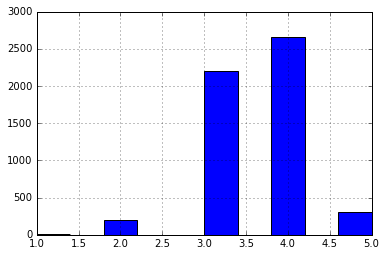

In [37]:
pd.Series(data=y5_train).hist()

In [38]:
pd.Series(data=y10_train).value_counts()

6     1539
7     1502
8     1003
5      809
9      310
4      130
3       37
10      29
2        1
dtype: int64

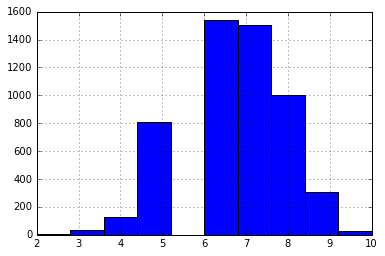

In [39]:
pd.Series(data=y10_train).hist()

Train our Naive Bayes models (for the 5 & 10 score), and then review the prediction result metrics:

In [40]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print 'X_train_counts.shape:' + str(X_train_counts.shape)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print 'X_train_tfidf.shape: ' + str(X_train_tfidf.shape)

# Train our Naive Bayes model
clf5 = MultinomialNB().fit(X_train_tfidf, y5_train)
clf10 = MultinomialNB().fit(X_train_tfidf, y10_train)

# Test our NB model
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

predicted5 = clf5.predict(X_test_tfidf)
predicted10 = clf10.predict(X_test_tfidf)

X_train_counts.shape:(5360, 11164)
X_train_tfidf.shape: (5360, 11164)


In [41]:
# Evaluate the results of the predictions: Range 1-5
cm5 = ConfusionMatrix(y5_test, predicted5)
cm5.print_stats()

Confusion Matrix:

Predicted  1  2    3     4  5  __all__
Actual                                
1          0  0    0     1  0        1
2          0  0   13    79  0       92
3          0  0  105   947  0     1052
4          0  0   50  1288  0     1338
5          0  0    4   154  0      158
__all__    0  0  172  2469  0     2641


Overall Statistics:

Accuracy: 0.527451722832
95% CI: (0.50820035491806381, 0.54664216487046713)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0557088483748
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                          1          2          3  \
Population                                    2641       2641       2641   
P: Condition positive                            1         92       1052   
N: Condition negative                         2640       2549       1589   
Test outcome positive                            0          0        172   
Test outcome negative                         2641       2641     

In [42]:
# Evaluate the results of the predictions: Range 1-5
cm10 = ConfusionMatrix(y10_test, predicted10)
cm10.print_stats()

Confusion Matrix:

Predicted  2  3  4  5     6     7  8  9  10  __all__
Actual                                              
2          0  0  0  0     0     1  0  0   0        1
3          0  0  0  0    20     7  0  0   0       27
4          0  0  0  0    40    21  0  0   0       61
5          0  0  0  0   269   133  0  0   0      402
6          0  0  0  0   445   262  2  0   0      709
7          0  0  0  0   394   354  0  0   0      748
8          0  0  0  0   271   243  3  0   0      517
9          0  0  0  0    75    88  1  0   0      164
10         0  0  0  0     4     8  0  0   0       12
__all__    0  0  0  0  1518  1117  6  0   0     2641


Overall Statistics:

Accuracy: 0.303672851193
95% CI: (0.28617135291477369, 0.32161055490754187)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0401584900873
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         2          3          4   \
Population                                    

In [43]:
# Perform some cross validation to verify findings.
X_counts = count_vect.fit_transform(X)
print 'X_train_counts.shape:' + str(X_counts.shape)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print 'X_train_tfidf.shape: ' + str(X_tfidf.shape)

scores5 = cross_val_score(clf5, X_tfidf, y5)
print 'Scores5: ' + str(scores5)

scores10 = cross_val_score(clf10, X_tfidf, y10)
print 'Scores10: ' + str(scores10)

X_train_counts.shape:(8001, 13151)
X_train_tfidf.shape: (8001, 13151)
Scores5: [ 0.50355939  0.51106112  0.50281426]
Scores10: [ 0.28988764  0.31221889  0.30078858]


In [44]:
dfData['rqual_score5'].value_counts()

4    3994
3    3256
5     462
2     287
1       2
Name: rqual_score5, dtype: int64

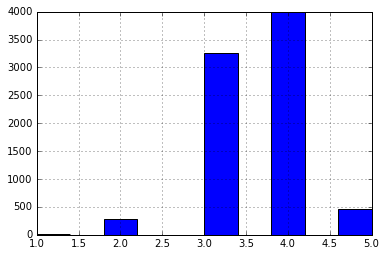

In [45]:
dfData['rqual_score5'].hist()

In [46]:
pd.Series(data=predicted5).value_counts()

4    2469
3     172
dtype: int64

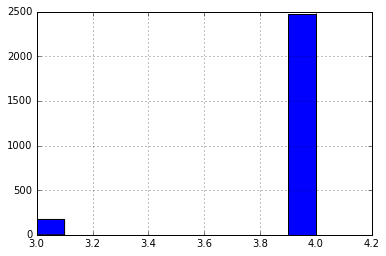

In [47]:
pd.Series(data=predicted5).hist()

In [48]:
dfData['rqual_score10'].value_counts()

7     2250
6     2248
8     1520
5     1211
9      474
4      191
3       64
10      41
2        2
Name: rqual_score10, dtype: int64

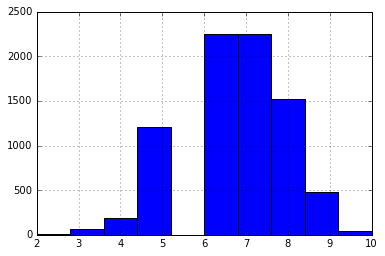

In [49]:
dfData['rqual_score10'].hist()

In [50]:
pd.Series(data=predicted10).value_counts()

6    1518
7    1117
8       6
dtype: int64

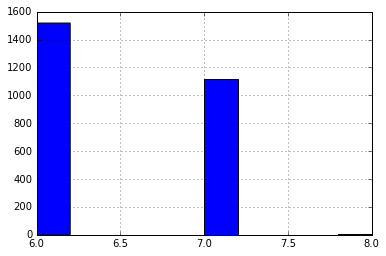

In [51]:
pd.Series(data=predicted10).hist()

## Results of Naive Bayes Classification predictor:

See a detailed explanation of the results of this model at https://docs.google.com/document/d/1UXa65kZc9XRZos21PUOtSPgLyLtPQkMsB0fXwEcX3p4/edit?usp=sharing

## Using Gensim's Word2Vec, create a model and perform "queries" against it.

In [7]:
# Get the property descriptions to process into sentence tokens.
query = 'select geo_listings.geo_code, \
        geo_listings.mls_id, \
        listings.property_description \
        from listings \
        join geo_listings \
        on listings.mls_id = geo_listings.mls_id \
        order by geo_listings.geo_code asc, geo_listings.mls_id;'
dfData = pd.read_sql(sql=query,con=conn)

In [8]:
# Build the sentence lists with each property description, split into sentence tokens.
sp = docProcessor(rtnType='sentence',stopwordList=stops)
sentenceList = []
for row in range(0,dfData.shape[0]):
    property_description = dfData.ix[row,'property_description']
    sentenceList.append(sp.transform(property_description))

# The previous loop created nested lists, 3 levels deep.  We only want it 2 levels deep, so collapse by 1 dimension.
flatSentenceList = []
for level2List in sentenceList:
    for level1List in level2List:
        flatSentenceList.append(level1List)

In [9]:
# Create the Word2Vec model.
model_unigram = models.Word2Vec(sentences = flatSentenceList,iter=5)

In [10]:
model_unigram.most_similar(positive=['house','pool'],topn=5)

[('swimming', 0.6435667872428894),
 ('sparkling', 0.5762478113174438),
 ('clubhouse', 0.5725579261779785),
 ('sauna', 0.5663540363311768),
 ('poolspa', 0.563408613204956)]

Try training the Word2Vec model with bigrams too.

In [11]:
bigram_transformer = Phrases(sentences=flatSentenceList)
model_bigram = models.Word2Vec(bigram_transformer[flatSentenceList], iter=5)

In [12]:
model_bigram.most_similar(positive=['foundation','electrical'], topn=5)

[(u'alarm', 0.9886112809181213),
 (u'hvac', 0.984927773475647),
 (u'year_old', 0.984806478023529),
 (u'solar_panels', 0.9847853779792786),
 (u'high_efficiency', 0.983464777469635)]